In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_classification.models import MobileNetV1
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = 43

In [18]:
len(train_dataset)

26640

37


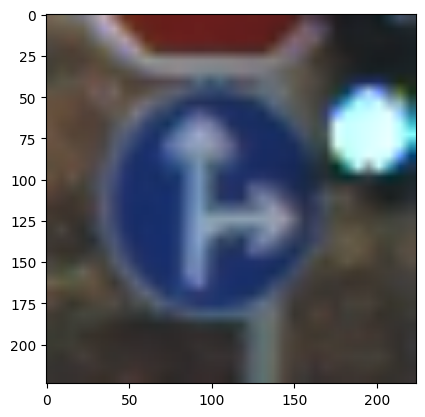

In [19]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [9]:
model = MobileNetV1(output_size=num_class).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
MobileNetV1                                   --
├─Sequential: 1-1                             --
│    └─ConvBnRelu: 2-1                        --
│    │    └─Conv2d: 3-1                       864
│    │    └─BatchNorm2d: 3-2                  64
│    │    └─ReLU: 3-3                         --
│    └─DepthwiseSeparableConv2d: 2-2          --
│    │    └─Sequential: 3-4                   2,528
│    └─DepthwiseSeparableConv2d: 2-3          --
│    │    └─Sequential: 3-5                   9,152
│    └─DepthwiseSeparableConv2d: 2-4          --
│    │    └─Sequential: 3-6                   18,048
│    └─DepthwiseSeparableConv2d: 2-5          --
│    │    └─Sequential: 3-7                   34,688
│    └─DepthwiseSeparableConv2d: 2-6          --
│    │    └─Sequential: 3-8                   68,864
│    └─DepthwiseSeparableConv2d: 2-7          --
│    │    └─Sequential: 3-9                   134,912
│    └─DepthwiseSeparableConv2d: 2-8    

# training

In [ ]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [ ]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [11]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [13]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 416/416 [01:22<00:00,  5.07it/s]


epoch 1: 0.00991192775535154


100%|██████████| 416/416 [01:23<00:00,  5.01it/s]


epoch 2: 0.003185402485332242


100%|██████████| 416/416 [01:24<00:00,  4.93it/s]


epoch 3: 0.0008711398004445138


100%|██████████| 416/416 [01:21<00:00,  5.11it/s]


epoch 4: 0.0003287355448385035


100%|██████████| 416/416 [01:23<00:00,  4.96it/s]


epoch 5: 0.00018564870236854015


100%|██████████| 416/416 [01:20<00:00,  5.14it/s]


epoch 6: 0.00011751038259102938


100%|██████████| 416/416 [01:19<00:00,  5.23it/s]


epoch 7: 9.57398811811805e-05


100%|██████████| 416/416 [01:20<00:00,  5.16it/s]


epoch 8: 8.210479754124462e-05


100%|██████████| 416/416 [01:19<00:00,  5.23it/s]


epoch 9: 6.888265350142035e-05


100%|██████████| 416/416 [01:11<00:00,  5.82it/s]

epoch 10: 4.68769425692057e-05


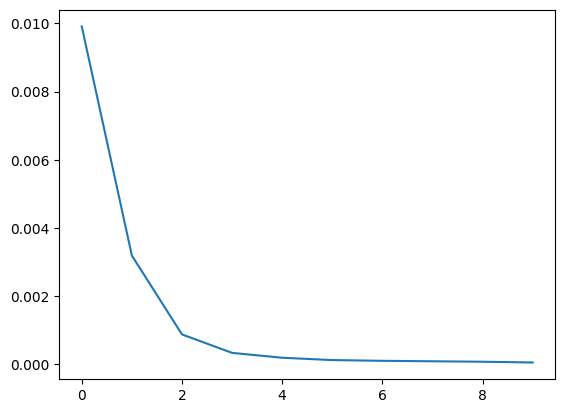

In [14]:
plt.plot(training_loss)

# inference

In [15]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [20]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [21]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [22]:
evaluator = ClassificationEvaluator(num_class, device)

In [23]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 198/198 [01:57<00:00,  1.69it/s]


In [24]:
print(confusion_matrix)

[[ 51   9   0 ...   0   0   0]
 [  2 693   9 ...   0   0   0]
 [  0   9 717 ...   0   0   0]
 ...
 [  0   0   0 ...  79   0   0]
 [  0   0   0 ...   0  36   5]
 [  0   0   0 ...   0   9  76]]


In [26]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.85
1         : 0.9625
2         : 0.956
3         : 0.8955555555555555
4         : 0.9772727272727273
5         : 0.873015873015873
6         : 0.7533333333333333
7         : 0.9466666666666667
8         : 0.7955555555555556
9         : 0.96875
10        : 0.990909090909091
11        : 0.9428571428571428
12        : 0.9637681159420289
13        : 0.9972222222222222
14        : 0.9925925925925926
15        : 0.9857142857142858
16        : 0.98
17        : 0.9861111111111112
18        : 0.7948717948717948
19        : 0.25
20        : 0.6888888888888889
21        : 0.4222222222222222
22        : 0.7416666666666667
23        : 0.9666666666666667
24        : 0.8777777777777778
25        : 0.9625
26        : 0.8944444444444445
27        : 0.5
28        : 0.92
29        : 0.8111111111111111
30        : 0.62
31        : 0.9555555555555556
32        : 1.0
33        : 0.8476190476190476
34        : 0.875
35        : 0.9769230769230769
36        : 0.7916666666666666
37        : 0.75

In [27]:
per_class_acc.mean()

0.8352882603951867

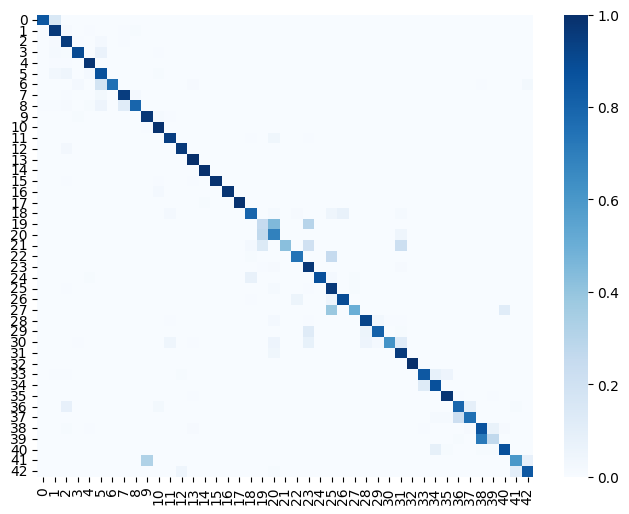

In [29]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [30]:
model_path = artifact_path / 'mobilenetV1.pth'

In [31]:
torch.save(model.state_dict(), model_path)

In [32]:
model_path.stat().st_size / 1024**2

12.541452407836914

In [34]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>